In [1]:
import yaml
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy
import numpy as np
from cycler import cycler

from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

custom_cycler = cycler(color=plt.get_cmap("tab10").colors) * cycler(
    linestyle=["solid", "dashed", "dotted", "dashdot"]
)
plt.rc("axes", prop_cycle=custom_cycler)

In [2]:
%%time
with open(
    "/home/vermarien/data2/uclchem-dev/v3.1.0/examples/test-output/phase1-full.yaml",
    "r",
) as fh:
    data_v3_1_p1 = yaml.safe_load(fh)
with open(
    "/home/vermarien/data2/uclchem-dev/v3.1.0-dev-h3tomolhydrogen/examples/test-output/phase1-full.yaml",
    "r",
) as fh:
    data_v3_2_p1 = yaml.safe_load(fh)
with open(
    "/home/vermarien/data2/uclchem-dev/v3.1.0/examples/test-output/phase2-full.yaml",
    "r",
) as fh:
    data_v3_1_p2 = yaml.safe_load(fh)
with open(
    "/home/vermarien/data2/uclchem-dev/v3.1.0-dev-h3tomolhydrogen/examples/test-output/phase2-full.yaml",
    "r",
) as fh:
    data_v3_2_p2 = yaml.safe_load(fh)

CPU times: user 1min 57s, sys: 210 ms, total: 1min 57s
Wall time: 1min 57s


In [3]:
def process_data(data, specie):
    key_destruction_reactions = {}
    key_production_reactions = {}
    data_copy = deepcopy(data[specie])
    for time_key in data_copy:
        key_destruction_reactions[time_key] = data_copy[time_key].pop(
            "key_destruction_reactions"
        )
        key_production_reactions[time_key] = data_copy[time_key].pop(
            "key_production_reactions"
        )
    df = pd.DataFrame.from_dict(data_copy).transpose()
    df.set_index("time", inplace=True)
    df["total_destruction"] *= -1  # make destruction positive so we can plot it.
    df_dest = pd.DataFrame.from_dict(key_destruction_reactions).transpose()
    df_dest.index.set_names(["Time"], inplace=True)
    df_prod = pd.DataFrame.from_dict(key_production_reactions).transpose()
    df_prod.index.set_names(["Time"], inplace=True)
    df_dest.columns = [
        name.replace(f"{specie} ", r" $\bf{" + str(specie) + "}$ ")
        for name in df_dest.columns
    ]
    df_prod.columns = [
        name.replace(f"{specie} ", r" $\bf{" + str(specie) + "}$ ")
        for name in df_prod.columns
    ]

    return {"df": df, "df_dest": df_dest, "df_prod": df_prod}

In [4]:
def plot_rates(df, df_dest, df_prod, fig=None, axes=None, xlim=[None, None]):
    if not fig:
        fig, axes = plt.subplots(
            4,
            1,
            figsize=(10, 10),
            sharex=True,
            tight_layout=True,
            height_ratios=[1, 1, 1, 0.25],
        )
    ax = df.plot(ax=axes[0])

    ax.set(xscale="log", yscale="log")
    ax = df_prod.plot(ax=axes[1], legend=False)
    ax.set(ylim=[1e-3, 1.1], ylabel="Production (%)")
    ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0)
    ax.set(xscale="log", yscale="log")
    ax = df_dest.plot(ax=axes[2], legend=False)
    ax.set(ylim=[1e-3, 1.1], ylabel="Destruction (%)")
    ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0)
    ax.set(xscale="log", yscale="log")
    if xlim[0] or xlim[1]:
        ax.set(xlim=xlim)
    axes[-1].scatter(df.index, df.index != -1)
    [ax.grid(alpha=0.5) for ax in axes]
    return fig, axes

Text(0.5, 0.98, 'Phase 1')

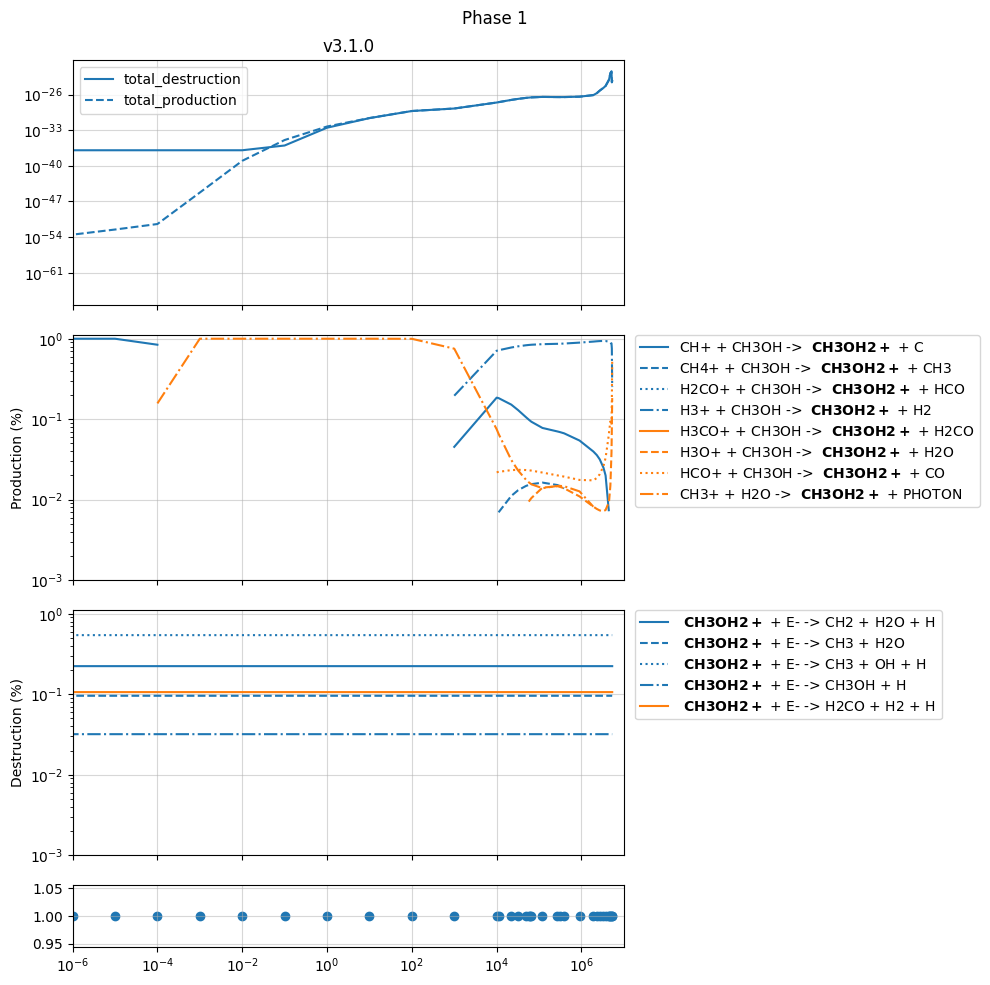

In [5]:
def analyze_rates(data, specie, axes, xlim):
    d1 = process_data(data, specie)
    plot_rates(**d1, fig=1, axes=axes, xlim=xlim)


fig, axes = plt.subplots(
    4,
    1,
    figsize=(10, 10),
    sharex=True,
    tight_layout=True,
    height_ratios=[1, 1, 1, 0.25],
)
xlim = [1e-6, 1e7]
analyze_rates(data_v3_1_p1, "CH3OH2+", axes=axes, xlim=xlim)
axes[0].set_title("v3.1.0")
fig.suptitle("Phase 1")

In [6]:
def sort_reaction_df(df, reference_df, common_dict):
    # write to dict because sorting indexes is weird
    df_dict = df.to_dict()
    ref_df_dict = reference_df.to_dict()
    # Sort the keys first by whether they are matching, then by the average values of the reference dictionary
    # If it is not matching, just sort by its own average value in descending order
    df_dict = dict(
        sorted(
            df_dict.items(),
            key=lambda kv: (
                int(kv[0] not in common_dict.keys()),
                -np.nanmean(list(ref_df_dict[kv[0]].values()))
                if kv[0] in common_dict.keys()
                else -np.nanmean(list(kv[1].values())),
            ),
        )
    )
    # temp_df = pd.DataFrame.from_dict(df_dict)
    # print("\n", "\n".join([f"{r}\t,{int(r not in common_dict)},\t{np.nanmean(df[r])}" for r in temp_df.columns]), "\n")
    return pd.DataFrame.from_dict(df_dict)


def plot_left_right(data1, data2, specie, xlim):
    fig, axes = plt.subplots(
        4,
        2,
        figsize=(20, 10),
        sharex=True,
        tight_layout=True,
        height_ratios=[1, 1, 3, 0.25],
    )
    d1 = process_data(data1, specie)
    d2 = process_data(data2, specie)
    # Make sure that the
    common_destruction_dict = {
        rf"{elem}": np.nanmean(d1["df_dest"][elem])
        for elem in set(d1["df_dest"].keys()).intersection(set(d2["df_dest"].keys()))
    }
    common_production_dict = {
        rf"{elem}": np.nanmean(d1["df_prod"][elem])
        for elem in set(d1["df_prod"].keys()).intersection(set(d2["df_prod"].keys()))
    }
    d1["df_dest"] = sort_reaction_df(
        d1["df_dest"], d1["df_dest"], common_destruction_dict
    )
    d2["df_dest"] = sort_reaction_df(
        d2["df_dest"], d1["df_dest"], common_destruction_dict
    )
    d1["df_prod"] = sort_reaction_df(
        d1["df_prod"], d1["df_prod"], common_production_dict
    )
    d2["df_prod"] = sort_reaction_df(
        d2["df_prod"], d1["df_prod"], common_production_dict
    )
    plot_rates(**d1, fig=1, axes=axes[:, 0], xlim=xlim)
    plot_rates(**d2, fig=1, axes=axes[:, 1], xlim=xlim)
    axes[0, 0].set_title("v3.1.0")
    axes[0, 1].set_title("v3.1.0-dev")
    return fig, axes

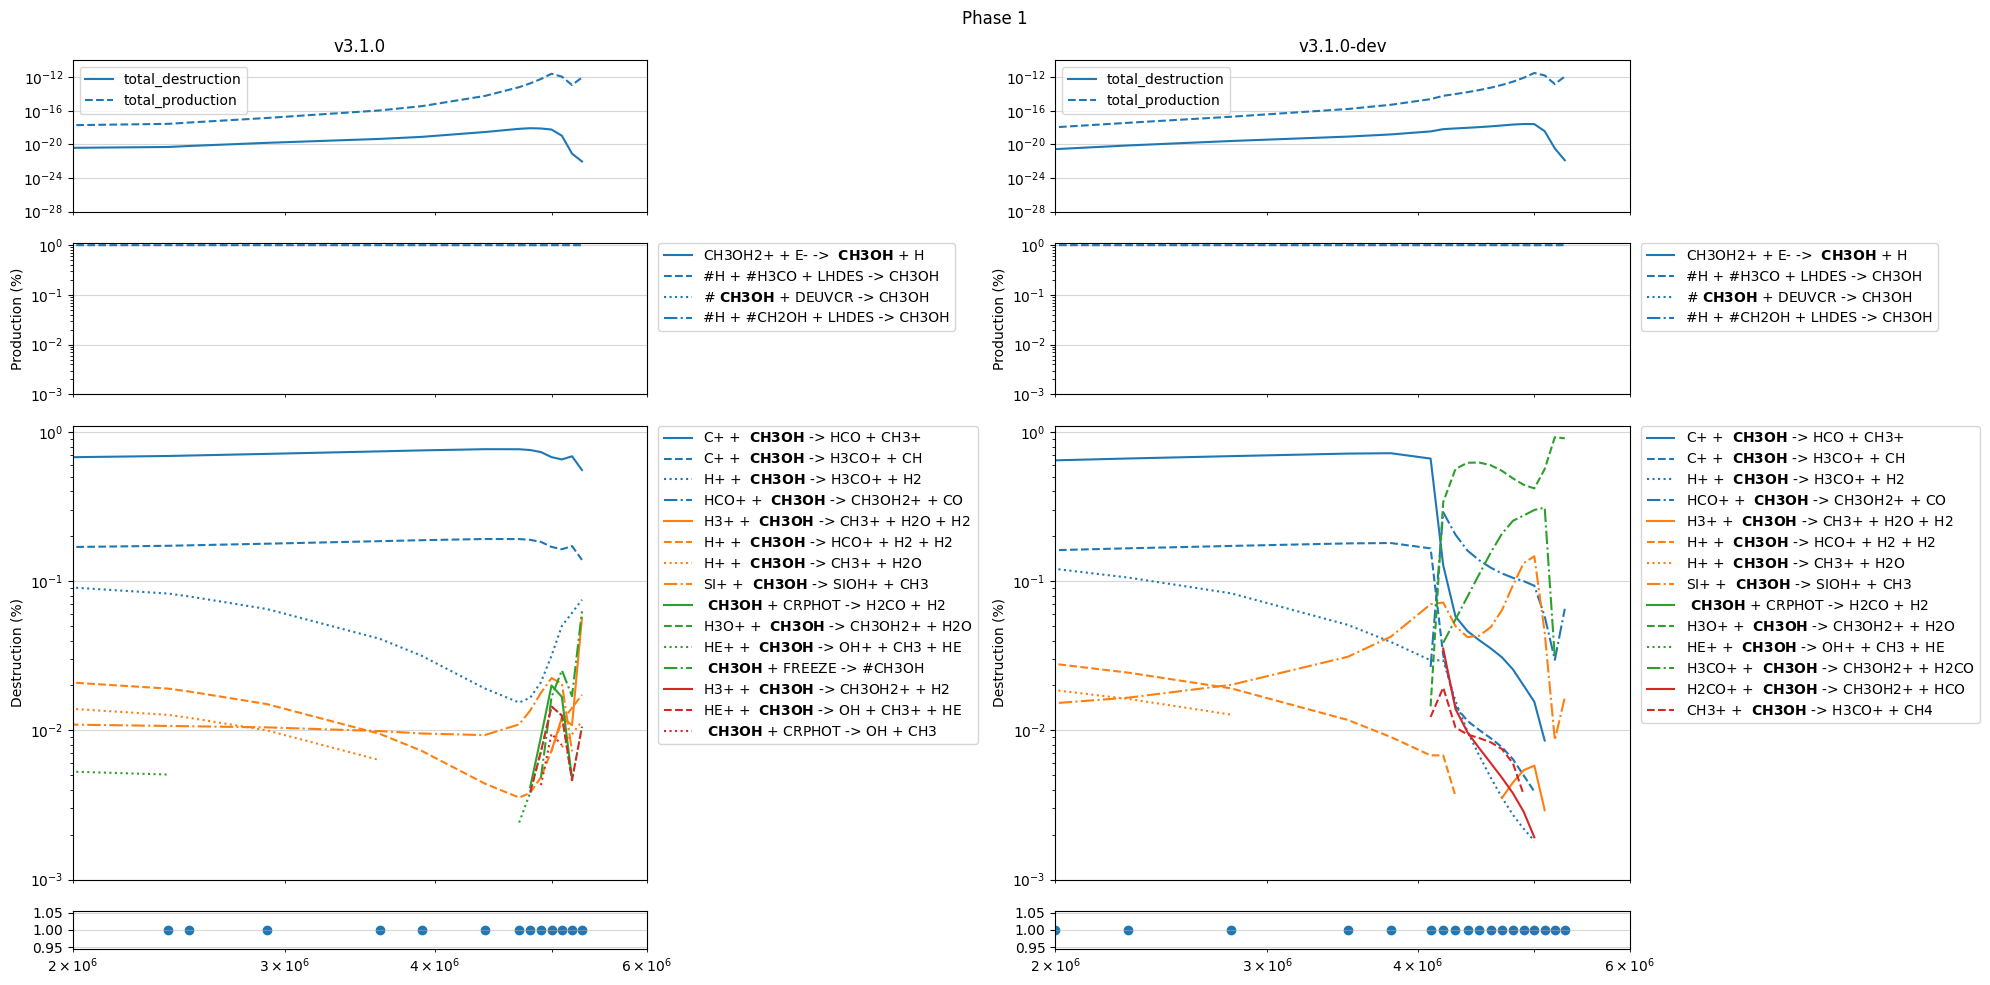

In [7]:
fig, axes = plot_left_right(data_v3_1_p1, data_v3_2_p1, "CH3OH", xlim=[2e6, 6e6])
[a.set_ylim(1e-28, 1e-10) for a in axes[0, :]]
fig.suptitle("Phase 1")

/data2/vermarien/uclchem-dev/uclchem-tools/.venv/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  func(*args, **kwargs)
/data2/vermarien/uclchem-dev/uclchem-tools/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


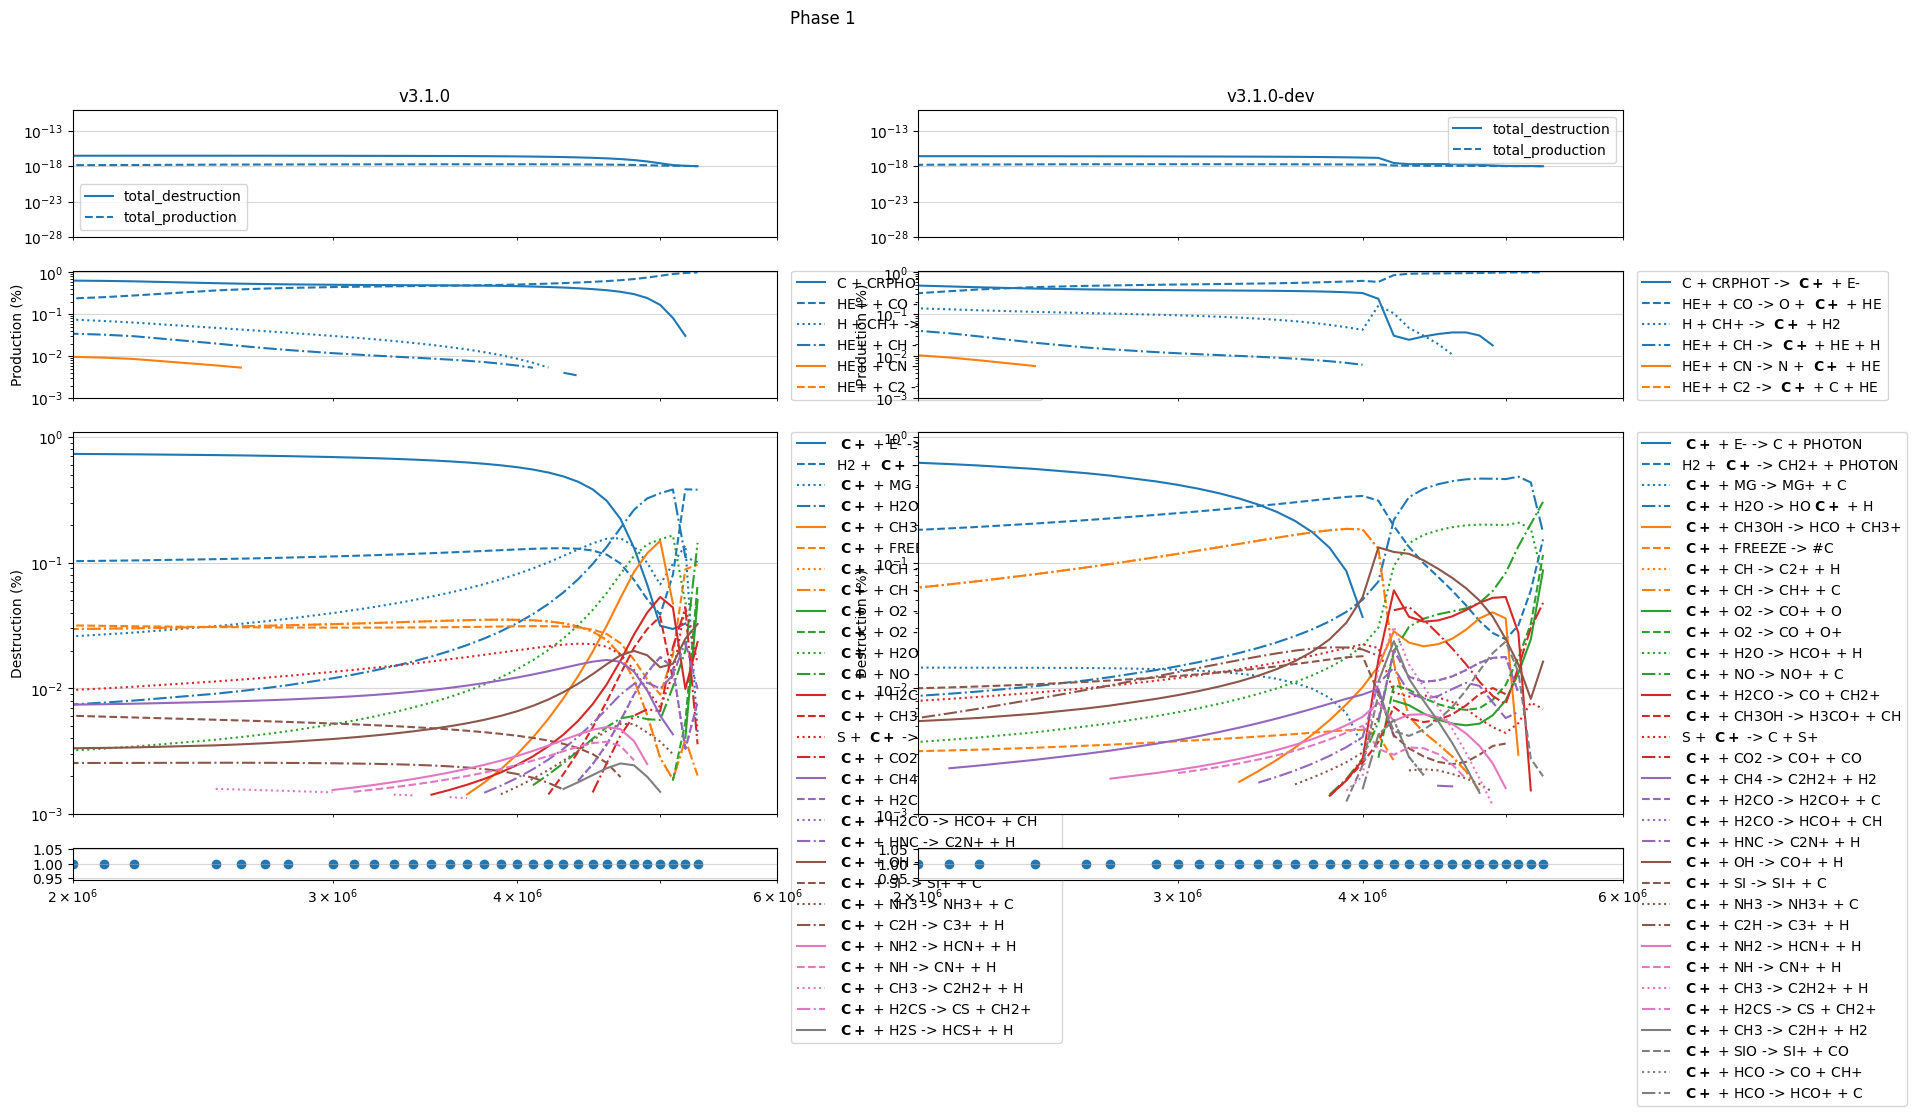

In [8]:
fig, axes = plot_left_right(data_v3_1_p1, data_v3_2_p1, "C+", xlim=[2e6, 6e6])
[a.set_ylim(1e-28, 1e-10) for a in axes[0, :]]
fig.suptitle("Phase 1")

/data2/vermarien/uclchem-dev/uclchem-tools/.venv/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  func(*args, **kwargs)
/data2/vermarien/uclchem-dev/uclchem-tools/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


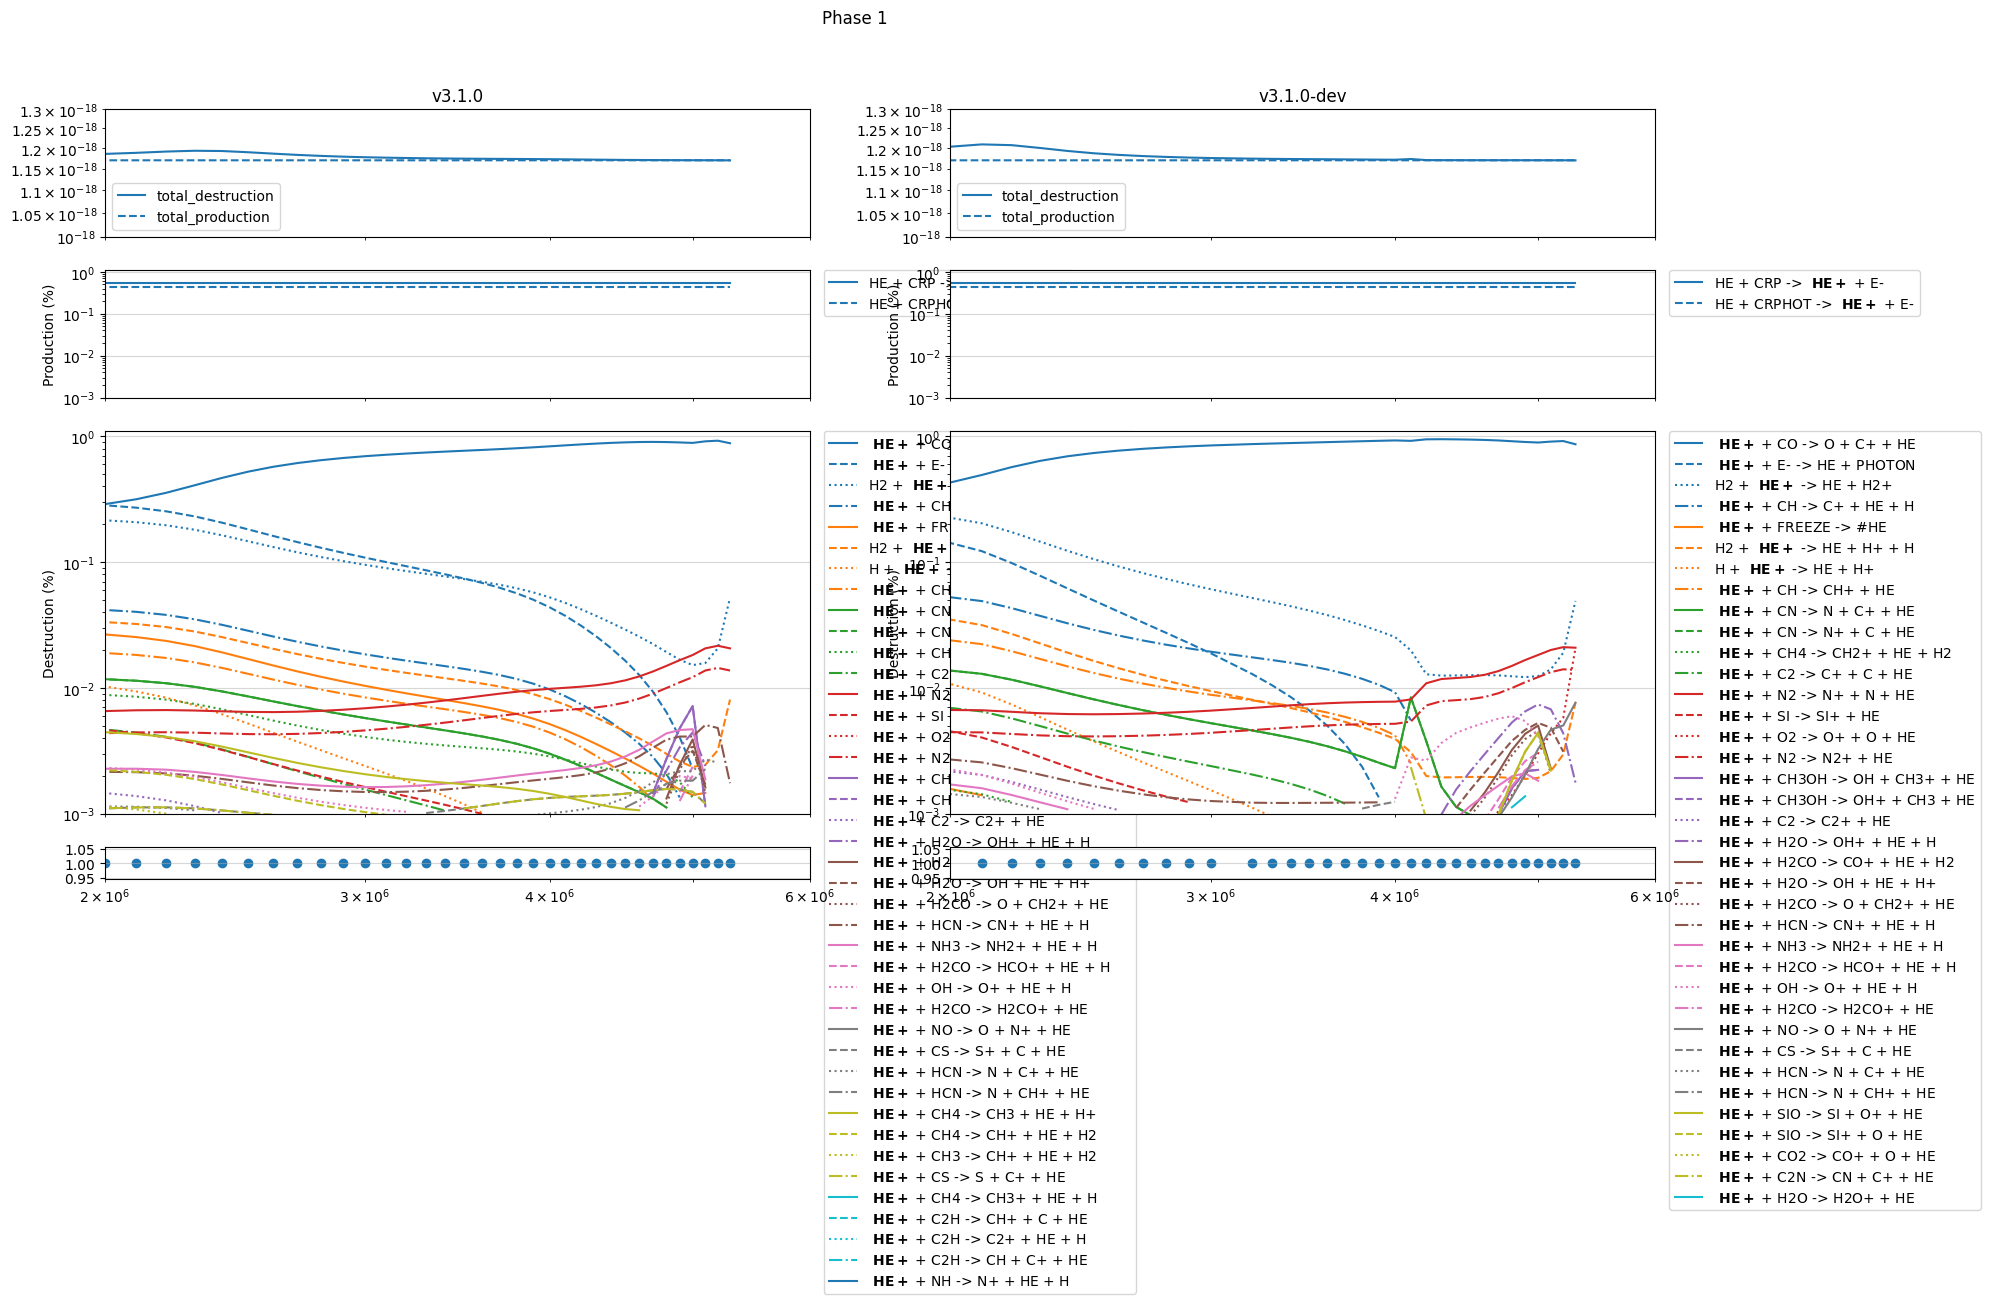

In [9]:
fig, axes = plot_left_right(data_v3_1_p1, data_v3_2_p1, "HE+", xlim=[2e6, 6e6])
[a.set_ylim(1e-18, 1.3e-18) for a in axes[0, :]]
fig.suptitle("Phase 1")

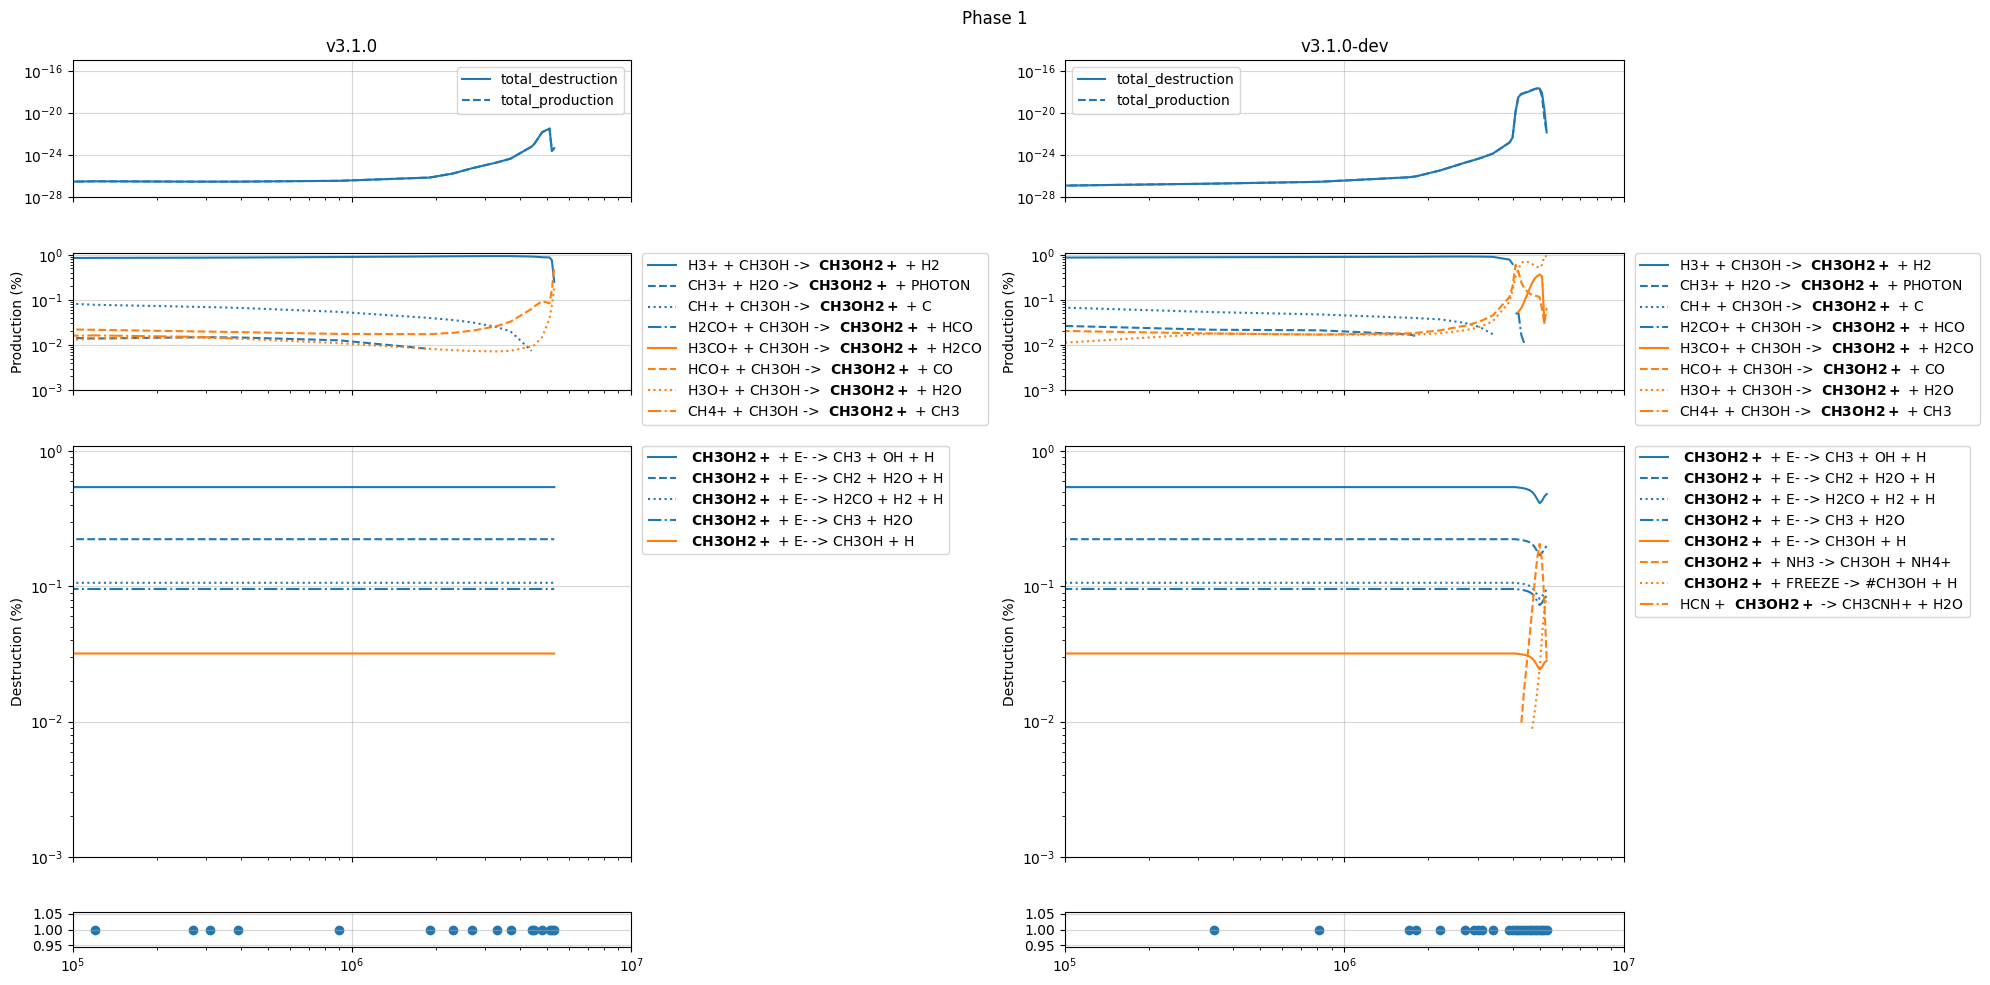

In [10]:
fig, axes = plot_left_right(data_v3_1_p1, data_v3_2_p1, "CH3OH2+", xlim=[1e5, 1e7])
[a.set_ylim(1e-28, 1e-15) for a in axes[0, :]]
fig.suptitle("Phase 1")

Text(0.5, 0.98, 'Phase 2')

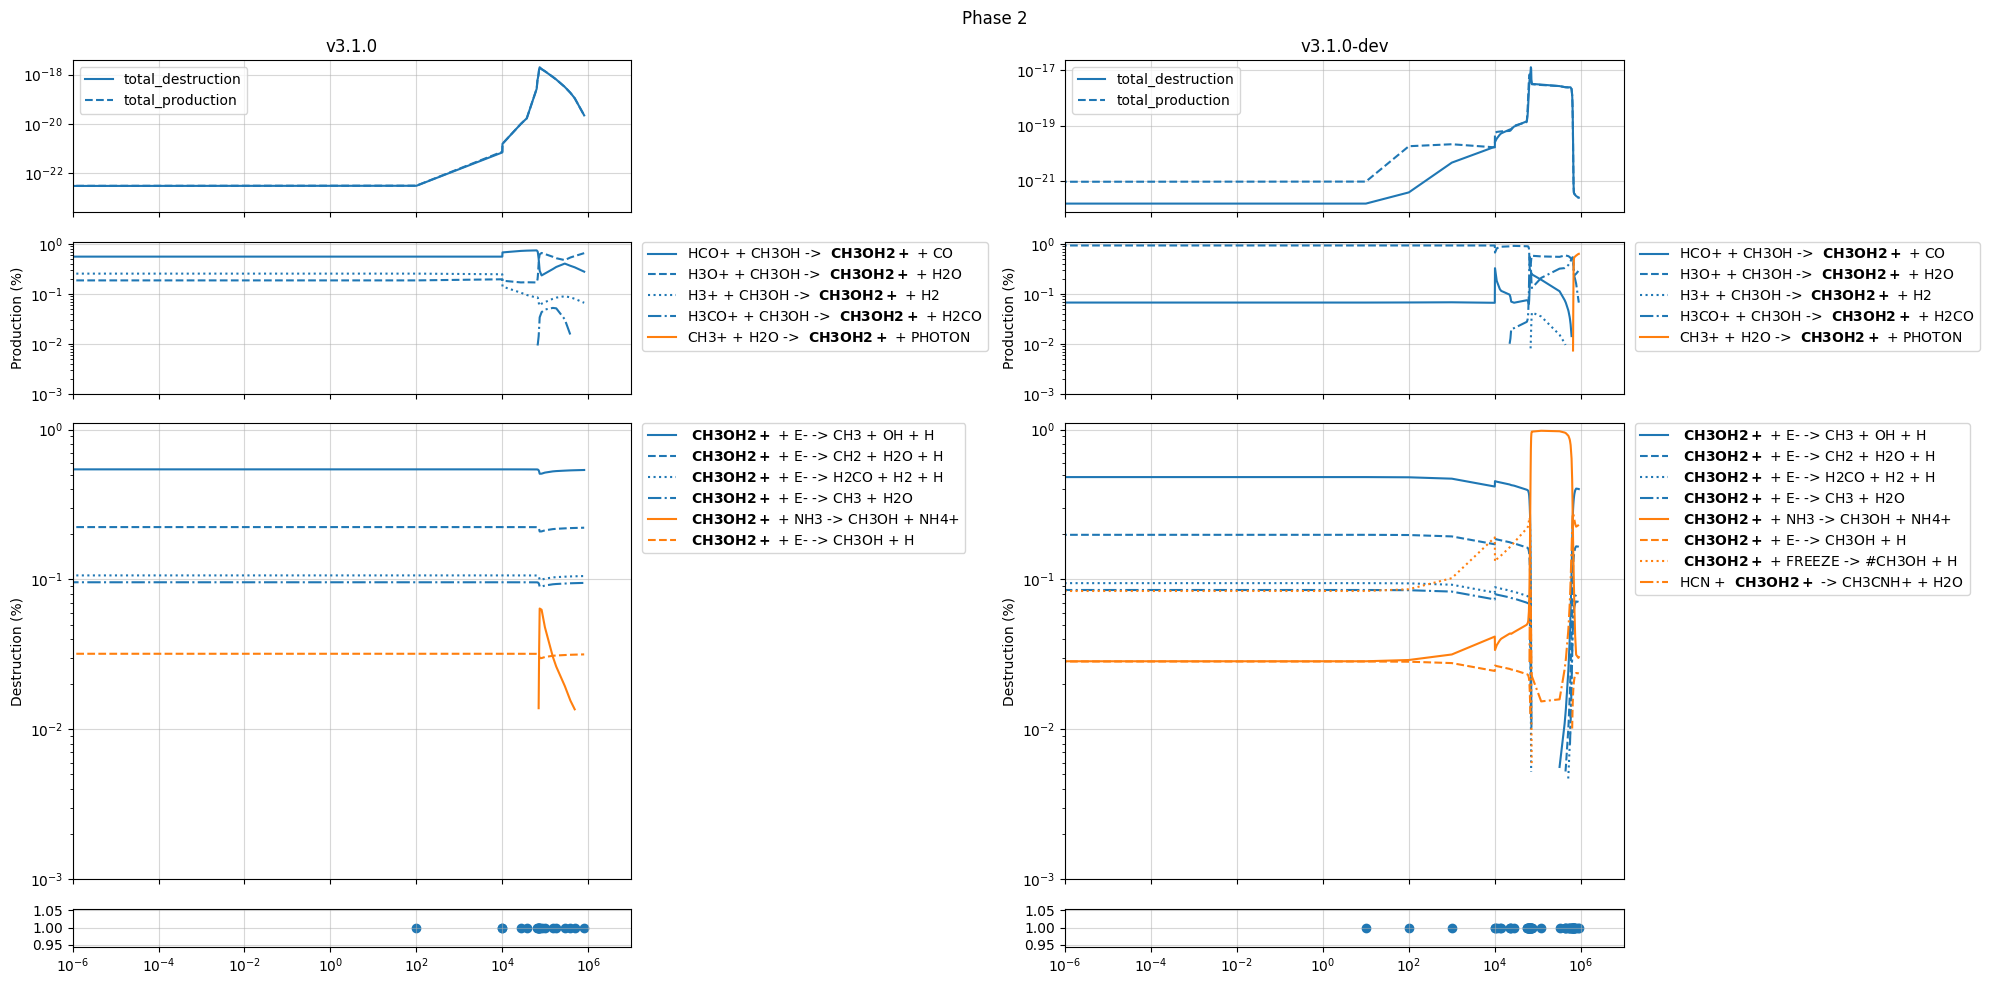

In [11]:
fig, axes = plot_left_right(data_v3_1_p2, data_v3_2_p2, "CH3OH2+", xlim=[1e-6, 1e7])
fig.suptitle("Phase 2")